In [2]:
import sys
sys.path.append('../')
sys.path.append('old/')

import pylab as pl
import numpy as np
from scipy import rand
import geom_impact_poly as poly
from scipy.constants import e, epsilon_0
import FiniteDifferences_ShortleyWeller_SquareGrid as PIC_FDSW
import FiniteDifferences_ShortleyWeller_SquareGrid_extrapolation as PIC_FDSWE

import FiniteDifferences_Staircase_SquareGrid as PIC_FDSC

import FFT_OpenBoundary_SquareGrid as PIC_FFT
import FFT_PEC_Boundary_SquareGrid as PIC_PEC_FFT


from pypic import PyPIC_Fortran_M2P_P2M, PyPIC
from meshing import RectMesh2D
from poisson_solver import FD_solver as FD
from poisson_solver import FFT_solver as FFT
from poisson_solver.FD_solver import laplacian_2D_5stencil

pycuda not found. no gpu capabilities will be available
pycuda not found. no gpu capabilities will be available
GPU libraries (pycuda, cusolver_RF) not found. GPU functionality not available.


In [3]:
na = np.array
Dh =1e-1
N_part_gen = 100000

tree = [[0,0],
		[1.,0],
		[1., 1,],
		[5.,1.],
		[2.,4.],
		[4,4],
		[2,7],
		[3,7],
		[1,9],
		[2,9],
		[0,11]]
		
tree=np.array(tree)
x_tree = tree[:,0]
y_tree = tree[:,1]

y_tree -= 6.

x_aper = 6.
y_aper = 7.

x_tree = np.array([0.]+ list(x_tree)+[0.])
y_tree = np.array([-y_aper]+ list(y_tree)+[y_aper])


		


x_part = x_aper*(2.*rand(N_part_gen)-1.)
y_part = y_aper*(2.*rand(N_part_gen)-1.)

x_on_tree = np.interp(y_part, y_tree, x_tree)

mask_keep = np.logical_and(np.abs(x_part)<x_on_tree, np.abs(x_part)>x_on_tree*0.8)
x_part = x_part[mask_keep]
y_part = y_part[mask_keep]

nel_part = 0*x_part+1


		


chamber = poly.polyg_cham_geom_object({'Vx':na([x_aper, -x_aper, -x_aper, x_aper]),
									   'Vy':na([y_aper, y_aper, -y_aper, -y_aper]),
									   'x_sem_ellip_insc':0.99*x_aper, 
									   'y_sem_ellip_insc':0.99*y_aper})

In [4]:
def test_new_solver(new_solver, xx, yy, charge=e, x_probe=None, y_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    mesh_charges = new_solver.particles_to_mesh(xx, yy, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(mesh_charges)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    for i, field in enumerate(mesh_e_fields):
        mesh_e_fields[i] = field.flatten()
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    return rho, phi, efx, efy, Ex, Ey

In [5]:
poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid_extrapolation(chamb=chamber, Dh=Dh)
poissonsolver_FFT = FFT.FFT_OpenBoundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)
poissonsolver_FFT_PEC = FFT.FFT_PEC_Boundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)

mesh = RectMesh2D(poissonsolver.bias_x,
                  poissonsolver.bias_y,
                  Dh, Dh,
                  poissonsolver.Nxg,
                  poissonsolver.Nyg)
#poissonsolver = FD.CPUFiniteDifferencePoissonSolver(mesh, laplacian_stencil=laplacian_2D_5stencil)

# new_pp = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver, gradient=poissonsolver.gradient)
# new_pp_FFT = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver_FFT)
# new_pp_FFT_PEC = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver_FFT_PEC)

new_pp = PyPIC(mesh, poissonsolver, gradient=poissonsolver.gradient)
new_pp_FFT = PyPIC(mesh, poissonsolver_FFT)
new_pp_FFT_PEC = PyPIC(mesh, poissonsolver_FFT_PEC)


picFDSC = PIC_FDSC.FiniteDifferences_Staircase_SquareGrid(chamb = chamber, Dh = Dh)
#picFDSW = PIC_FDSW.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFDSWE = PIC_FDSWE.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFDSW = picFDSWE
picFFTPEC = PIC_PEC_FFT.FFT_PEC_Boundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh)
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh)

picFDSC.scatter(x_part, y_part, nel_part, charge=e)
picFDSW.scatter(x_part, y_part, nel_part, charge=e)
picFFTPEC.scatter(x_part, y_part, nel_part, charge=e)
picFFT.scatter(x_part, y_part, nel_part, charge=e)


picFDSC.solve()
picFDSW.solve()
picFFTPEC.solve()
picFFT.solve()

rho_FFT, phi_FFT, efx_FFT, efy_FFT, fx_FFT, fy_FFT = test_new_solver(new_pp_FFT, xx=x_part, yy=y_part,
                                                                     charge=e,
                                                                     x_probe=x_part, y_probe=y_part)

rho_FFT_PEC, phi_FFT_PEC, efx_FFT_PEC, efy_FFT_PEC, fx_FFT_PEC, fy_FFT_PEC = test_new_solver(new_pp_FFT_PEC,
                                                                                             xx=x_part,
                                                                                             yy=y_part,
                                                                                             charge=e,
                                                                                             x_probe=x_part,
                                                                                             y_probe=y_part)

rho, phi, efx, efy, fx, fy = test_new_solver(new_pp, xx=x_part, yy=y_part,
                                             charge=e,
                                             x_probe=x_part, y_probe=y_part)


Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Using scipy superlu solver...
Done PIC init.
Failed to import pyfftw
Got exception:  No module named pyfftw
Using numpy fft
Failed to import pyfftw
Got exception:  No module named pyfftw
Using numpy fft
Start PIC init.:
Finite Differences, Square Grid
PyPIC Version 1.02
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembl

old/geom_impact_poly.py:157: RuntimeWarning: divide by zero encountered in divide
  (self.Nx[ii]*(x_out-x_in)+self.Ny[ii]*(y_out-y_in))


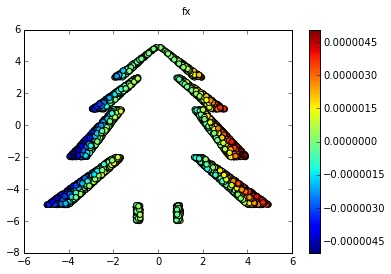

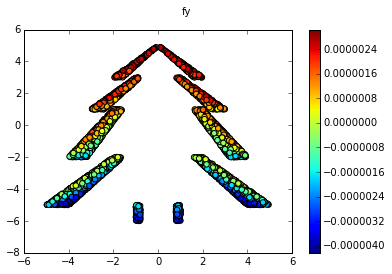

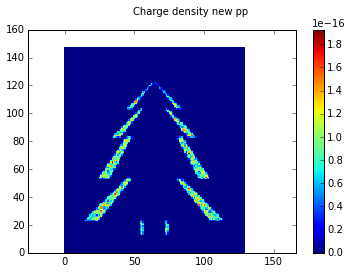

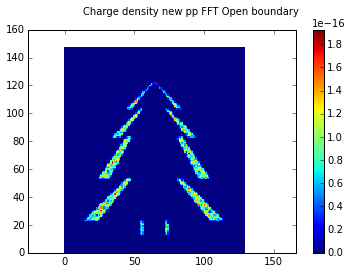

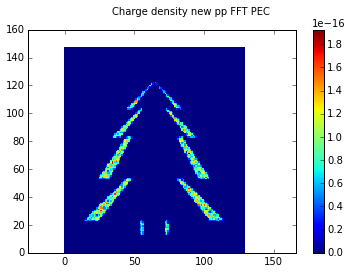

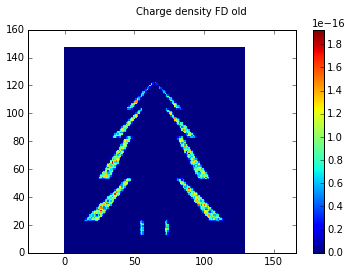

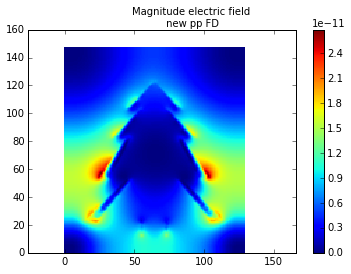

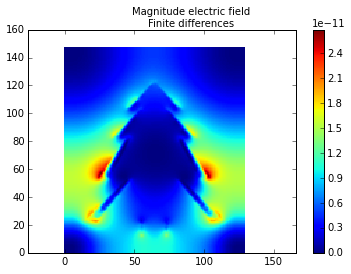

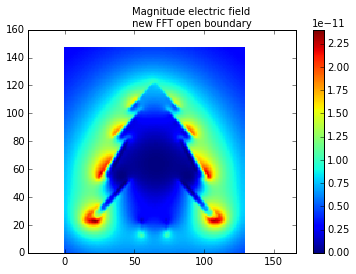

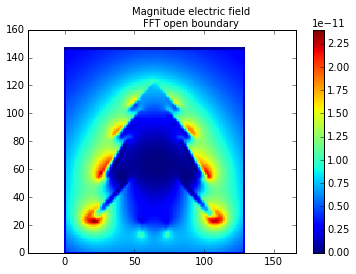

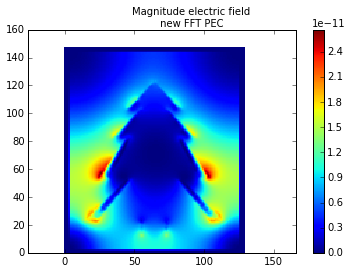

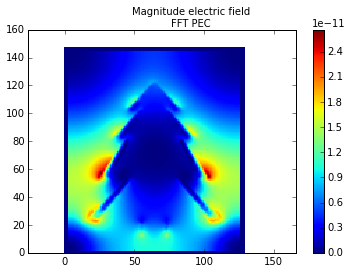

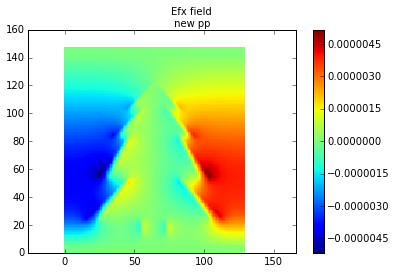

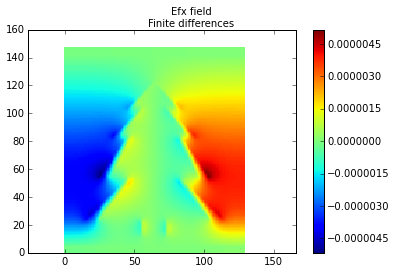

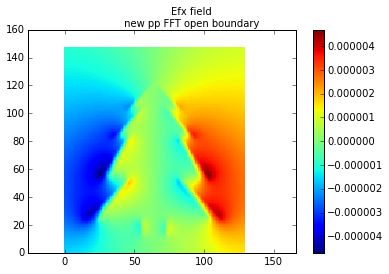

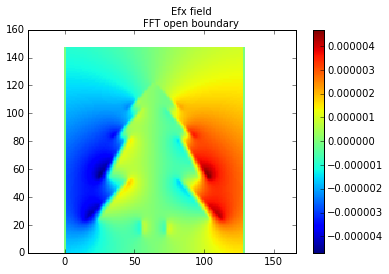

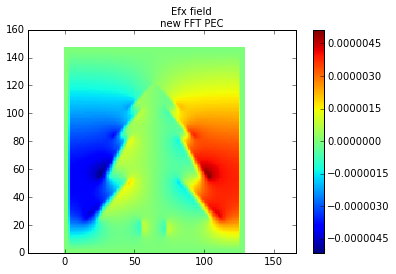

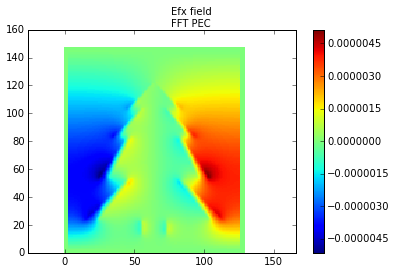

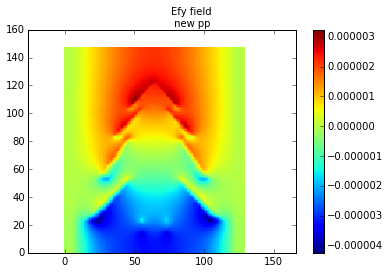

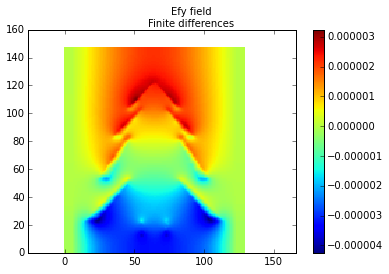

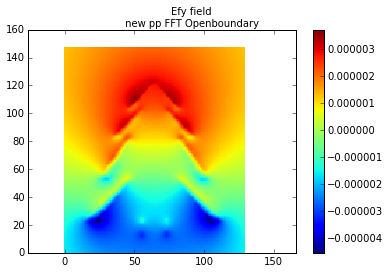

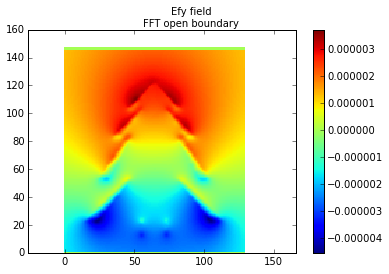

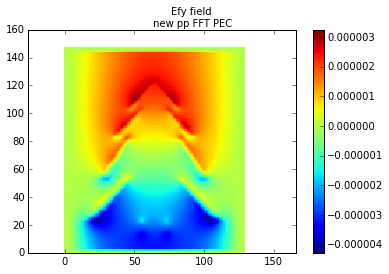

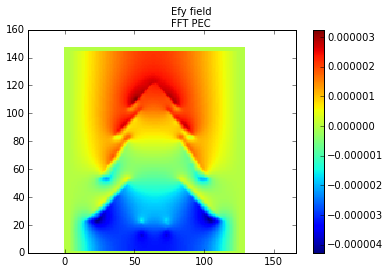

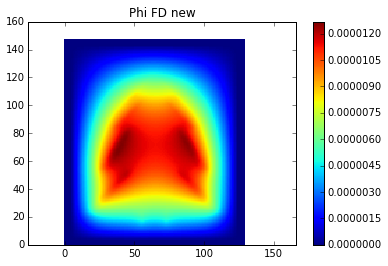

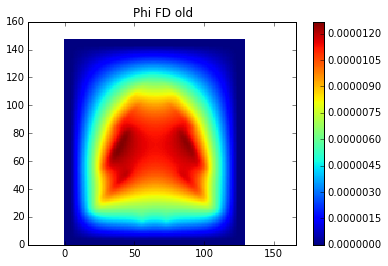

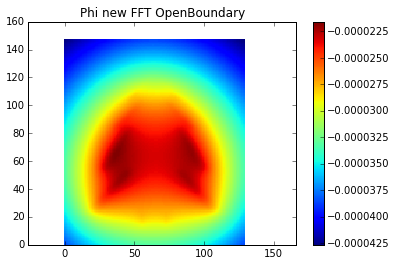

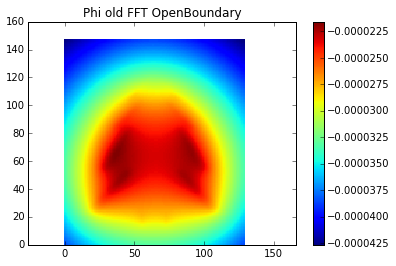

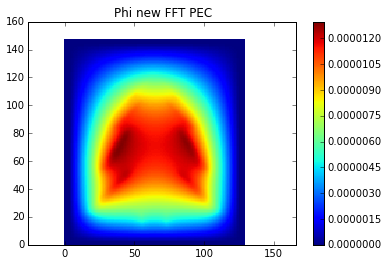

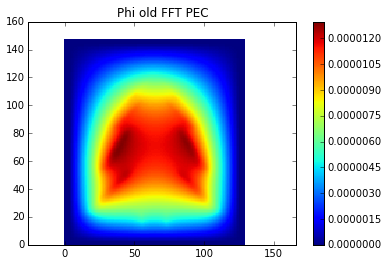

(129, 147)
(129, 147)
(129, 147)
(129, 147)
(129, 147)
(129, 147)


In [8]:
%matplotlib inline

###################### efield per particle
pl.figure()
pl.scatter(x_part, y_part, c=fx, s=30)
pl.suptitle('fx')
pl.colorbar()

pl.figure()
pl.scatter(x_part, y_part, c=fy, s=30)
pl.suptitle('fy')
pl.colorbar()


###################### charge density


pl.figure()
pl.pcolor(rho.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density new pp')

pl.figure()
pl.pcolor(rho_FFT.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density new pp FFT Open boundary')

pl.figure()
pl.pcolor(rho_FFT_PEC.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density new pp FFT PEC')

pl.figure()
pl.pcolor(picFDSW.rho.T)
pl.axis('equal')
pl.colorbar()
pl.suptitle('Charge density FD old')


###################### magnitude electric field

pl.figure()
pl.pcolor((efx.reshape(mesh.ny, mesh.nx)**2+efy.reshape(mesh.ny, mesh.nx)**2))
pl.axis('equal')
pl.suptitle('Magnitude electric field\n new pp FD')
pl.colorbar()

pl.figure()
pl.pcolor((picFDSW.efx**2+picFDSW.efy**2).T)
pl.axis('equal')
pl.suptitle('Magnitude electric field\nFinite differences')
pl.colorbar()

pl.figure()
pl.pcolor((efx_FFT.reshape(mesh.ny, mesh.nx)**2+efy_FFT.reshape(mesh.ny, mesh.nx)**2))
pl.axis('equal')
pl.suptitle('Magnitude electric field\n new FFT open boundary')
pl.colorbar()

pl.figure()
pl.pcolor((picFFT.efx**2+picFFT.efy**2).T)
pl.axis('equal')
pl.suptitle('Magnitude electric field\nFFT open boundary')
pl.colorbar()

pl.figure()
pl.pcolor((efx_FFT_PEC.reshape(mesh.ny, mesh.nx)**2+efy_FFT_PEC.reshape(mesh.ny, mesh.nx)**2))
pl.axis('equal')
pl.suptitle('Magnitude electric field\n new FFT PEC')
pl.colorbar()

pl.figure()
pl.pcolor((picFFTPEC.efx**2+picFFTPEC.efy**2).T)
pl.axis('equal')
pl.suptitle('Magnitude electric field\nFFT PEC')
pl.colorbar()



########################## electric field x
pl.figure()
pl.pcolor(efx.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efx field\n new pp')
pl.colorbar()

pl.figure()
pl.pcolor(picFDSW.efx.T)
pl.axis('equal')
pl.suptitle('Efx field\nFinite differences')
pl.colorbar()

pl.figure()
pl.pcolor(efx_FFT.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efx field\n new pp FFT open boundary')
pl.colorbar()

pl.figure()
pl.pcolor(picFFT.efx.T)
pl.axis('equal')
pl.suptitle('Efx field\nFFT open boundary')
pl.colorbar()

pl.figure()
pl.pcolor(efx_FFT_PEC.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efx field\n new FFT PEC')
pl.colorbar()

pl.figure()
pl.pcolor(picFFTPEC.efx.T)
pl.axis('equal')
pl.suptitle('Efx field\nFFT PEC')
pl.colorbar()
pl.figure()


############################## electric field y

pl.figure()
pl.pcolor(efy.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efy field\n new pp')
pl.colorbar()

pl.figure()
pl.pcolor(picFDSW.efy.T)
pl.axis('equal')
pl.suptitle('Efy field\nFinite differences')
pl.colorbar()

pl.figure()
pl.pcolor(efy_FFT.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efy field\n new pp FFT Openboundary')
pl.colorbar()

pl.figure()
pl.pcolor(picFFT.efy.T)
pl.axis('equal')
pl.suptitle('Efy field\nFFT open boundary')
pl.colorbar()

pl.figure()
pl.pcolor(efy_FFT_PEC.reshape(mesh.ny, mesh.nx))
pl.axis('equal')
pl.suptitle('Efy field\n new pp FFT PEC')
pl.colorbar()

pl.figure()
pl.pcolor(picFFTPEC.efy.T)
pl.axis('equal')
pl.suptitle('Efy field\nFFT PEC')
pl.colorbar()
pl.figure()

########################## electric potential

pl.figure()
pl.pcolor(phi.reshape(mesh.ny, mesh.nx))
pl.colorbar()
pl.axis('equal')
pl.title('Phi FD new')
pl.show()

pl.figure()
pl.pcolor(picFDSW.phi.T)
pl.colorbar()
pl.axis('equal')
pl.title('Phi FD old')
pl.show()

pl.figure()
pl.pcolor(phi_FFT.reshape(mesh.ny, mesh.nx))
pl.colorbar()
pl.axis('equal')
pl.title('Phi new FFT OpenBoundary')
pl.show()

pl.figure()
pl.pcolor(picFFT.phi.T)
pl.colorbar()
pl.title('Phi old FFT OpenBoundary')
pl.axis('equal')
pl.show()

pl.figure()
pl.pcolor(phi_FFT_PEC.reshape(mesh.ny, mesh.nx))
pl.colorbar()
pl.axis('equal')
pl.title('Phi new FFT PEC')
pl.show()

pl.figure()
pl.pcolor(picFFTPEC.phi.T)
pl.colorbar()
pl.title('Phi old FFT PEC')
pl.axis('equal')
pl.show()

print(picFDSC.phi.shape)
print(picFDSC.efx.shape)
print(picFDSC.efy.shape)

print(picFFTPEC.phi.shape)
print(picFFTPEC.efx.shape)
print(picFFTPEC.efy.shape)